### Full DnW Conversion ###

Converting both temperature to demand and wind speed to wind power generation, then taking the difference to calculate demand net wind. All in the same notebook.

Wind speed -> Wind power generation conversion first

In [1]:
# Local imports
import os
import sys
import time
import argparse

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import plot_distributions_fidelity, plot_cdfs, \
    plot_qq, plot_rp_extremes, estimate_period, sigmoid

In [3]:
# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# Load the model data
df_model_sfcWind = pd.read_csv(f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_United_Kingdom_1960-2018_day.csv")

# set up the df obs sfcwing
df_obs_sfcWind = pd.read_csv("/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_sfcWind_United_Kingdom_1960-2018_daily_2024-12-11.csv")

# load the clearheads data for wind generation
df_ch = pd.read_csv("/home/users/benhutch/unseen_multi_year/dfs/UK_clearheads_data_daily_1960_2018_ONDJFM.csv")

In [4]:
# Clean the obs data
df_obs_sfcWind["time"] = pd.to_datetime(df_obs_sfcWind["time"],
                                    origin='1952-01-01', unit='D')

# subset the data to O, N, D, J, F, M
df_obs_sfcWind = df_obs_sfcWind[
    df_obs_sfcWind['time'].dt.month.isin([10, 11, 12, 1, 2, 3])
]

In [5]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm= pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_sfcWind[df_model_sfcWind["lead"].isin(leads)]

    # include a new column

    # Append to the new df
    df_model_ondjfm = pd.concat([df_model_ondjfm, df_model_leads_this])

In [6]:
df_ch.head()

,date,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
0,1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,15.744187,25.022648,25.922391
1,1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,3.883881,36.135318,39.979230
2,1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,8.359369,29.590107,34.280923
3,1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,13.176714,26.599156,27.407426
4,1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,17.378747,25.382651,25.382651


In [7]:
df_obs_sfcWind.tail()

,time,data
21545,2018-12-27,2.477261
21546,2018-12-28,3.448565
21547,2018-12-29,5.573635
21548,2018-12-30,4.381348
21549,2018-12-31,5.464558


In [8]:
df_model_sfcWind.head()

,init_year,member,lead,data
0,1960,1,1,8.429288
1,1960,1,2,9.267500
2,1960,1,3,7.539931
3,1960,1,4,7.504783
4,1960,1,5,5.574239


Calculating bootstrap statistics:   0%|          | 1/1000 [00:00<01:49,  9.12it/s]

Calculating bootstrap statistics: 100%|██████████| 1000/1000 [01:53<00:00,  8.80it/s]


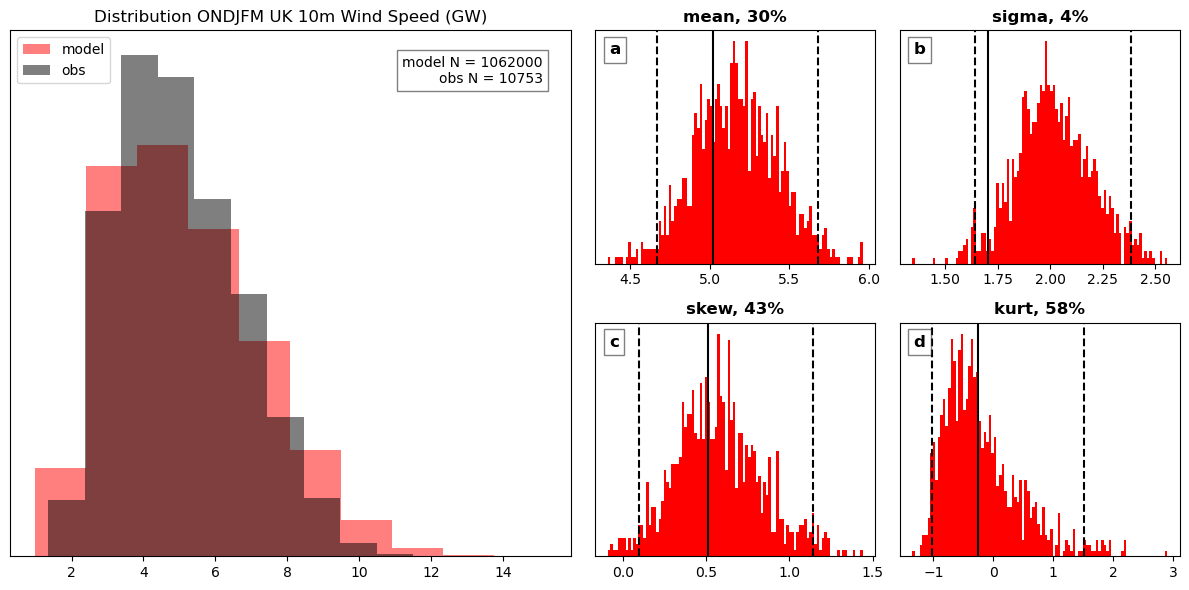

In [9]:
# Plot the distribution of 10m wind speed
plot_distributions_fidelity(
    obs_df=df_obs_sfcWind,
    model_df=df_model_ondjfm,
    obs_val_name="data",
    model_val_name="data",
    obs_time_name="time",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK 10m Wind Speed (GW)",
    nboot=1000,
    figsize=(12, 6),
    fname_prefix="UK_10m_wind_speed_ONDJFM_fidelity",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Now fit the sigmoid